In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [3]:
from PIL import Image

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
pred_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [5]:
from pathlib import Path

In [6]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = Path(path)
        self.transform = transform
        self.classes = sorted(os.listdir(path))
        self.img_path = []
        self.img_labels = []
        self.class_names = sorted([d.name for d in self.path.iterdir() if d.is_dir()])
        for label, class_name in enumerate(self.class_names):
            class_dir = self.path/class_name
            for img_file in class_dir.iterdir():
                if img_file.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                    self.img_path.append(str(img_file))
                    self.img_labels.append(label)
            print(f"✅ Loaded {len(self.img_path)} images from {len(self.class_names)} classes")
    def __len__(self):
        return len(self.img_path)
    def __getitem__(self, index):
        image = Image.open(self.img_path[index]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.img_labels[index]

In [7]:
path  = "/kaggle/input/ai-art-vs-human-art/Art"
datasets = CustomDataset(path, train_transforms)
dataloader = DataLoader(datasets, batch_size=32, shuffle=True, pin_memory=True)

✅ Loaded 536 images from 2 classes
✅ Loaded 970 images from 2 classes


In [8]:
class ai_vs_real_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=2,stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32,64,kernel_size=2,stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=2,stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
num_classes = len(datasets.classes)
model = ai_vs_real_model(num_classes).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs=10

In [12]:
def train(dataloader, model, optimizer, loss):
    running_loss = 0.0
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x,y) in enumerate(dataloader):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yhat = model(x)
            criterion = loss(yhat, y)
            criterion.backward()
            optimizer.step()
            running_loss+= criterion.item()
            print(f"Epoch: {epoch}/{epochs}| Batch_Index: {batch_idx} | Loss: {criterion.item()}")
    torch.save(model.state_dict(),"ai_vs_real.pth") 
    print("✅ Model is Saved")
    return running_loss

In [13]:
train(dataloader, model, optimizer, loss)

Epoch: 0/10| Batch_Index: 0 | Loss: 0.7304203510284424
Epoch: 0/10| Batch_Index: 1 | Loss: 3.087724208831787
Epoch: 0/10| Batch_Index: 2 | Loss: 0.9976866841316223
Epoch: 0/10| Batch_Index: 3 | Loss: 2.1425840854644775
Epoch: 0/10| Batch_Index: 4 | Loss: 1.072941541671753
Epoch: 0/10| Batch_Index: 5 | Loss: 2.160663604736328
Epoch: 0/10| Batch_Index: 6 | Loss: 2.0051512718200684


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 0/10| Batch_Index: 7 | Loss: 0.8516079187393188
Epoch: 0/10| Batch_Index: 8 | Loss: 0.9398188591003418
Epoch: 0/10| Batch_Index: 9 | Loss: 0.869411826133728
Epoch: 0/10| Batch_Index: 10 | Loss: 1.112909197807312
Epoch: 0/10| Batch_Index: 11 | Loss: 0.7885525226593018
Epoch: 0/10| Batch_Index: 12 | Loss: 0.7039233446121216
Epoch: 0/10| Batch_Index: 13 | Loss: 0.7783166170120239
Epoch: 0/10| Batch_Index: 14 | Loss: 0.6268026232719421
Epoch: 0/10| Batch_Index: 15 | Loss: 0.6076256036758423
Epoch: 0/10| Batch_Index: 16 | Loss: 0.8408975601196289
Epoch: 0/10| Batch_Index: 17 | Loss: 0.6031866073608398
Epoch: 0/10| Batch_Index: 18 | Loss: 1.092883586883545
Epoch: 0/10| Batch_Index: 19 | Loss: 0.7471761703491211
Epoch: 0/10| Batch_Index: 20 | Loss: 0.7299303412437439
Epoch: 0/10| Batch_Index: 21 | Loss: 0.9009404182434082
Epoch: 0/10| Batch_Index: 22 | Loss: 0.6670259237289429
Epoch: 0/10| Batch_Index: 23 | Loss: 0.7429796457290649
Epoch: 0/10| Batch_Index: 24 | Loss: 0.646441400051116

198.30258738994598

In [14]:
# Redefining the model class 
import torch

model = ai_vs_real_model(num_classes)

state_dict = torch.load(
    "/kaggle/working/ai_vs_real.pth",
    map_location="cuda"   # or "cuda"
)

model.load_state_dict(state_dict)
model.eval()

ai_vs_real_model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3):

In [15]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [16]:
def pred(upload_file):
    class_names = ["AI Art", "Human Art"]
    model.eval()

    img = Image.open(upload_file).convert("RGB")
    img_tensor = pred_transforms(img).unsqueeze(0)
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        conf, predict = torch.max(probs,1)
    label = class_names[predict.item()]
    confidence = conf.item() * 100

    plt.imshow(img)
    plt.title(f"{label}, with accuracy {confidence:4f}")
    plt.axis("off")
    plt.show()

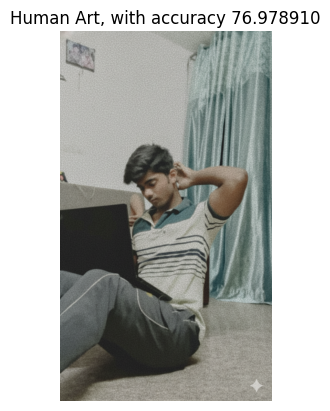

In [17]:
pred("/kaggle/input/my-image/Generated Image December 22 2025 - 1_15PM.png")